# Reeading Genesis files and propagating an electric field using Fourier Optics
awojdyla@lbl.gov, Oct 2025

We want to read data generated by [Genesis](https://github.com/svenreiche/Genesis-1.3-Version4), propagate it through some distance, and assess the effects of a grating. 

For this, we used some sample data provided by Sam Barber and Tehya Anderson fromn LBNL BELLA.

Additional notes are available here: https://docs.google.com/document/d/1KjcW7mscPBQP6BWLpjh07FvK8Smeei6KhIumcfoLdSw/edit?usp=sharing

# Loading Genesis data
The data was provided here: through a shared google drive folder:
https://drive.google.com/drive/folders/1hmTQ3kMD-mZNx9qRGzTQC3zJK6cjTA01?usp=drive_link

We are using a python function provided by Sam Barber to open the file `result.out.80.fld.h5`

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# function to load a genesis4 field file
def load_genesis4_fields(h5):
    """
    Loads the field data into memory from an open h5 handle.

    Example usage:

    import h5py
    with h5py.File('rad_field.fld.h5', 'r') as h5:
        dfl, param = load_genesis4_fields(h5)

    Returns tuple (dfl, param) where

        dfl is a 3d complex dfl grid with shape (nx, ny, nz)

        param is a dict with:
            gridpoints:    number of gridpoints in one transverse dimension, equal to nx and ny above
            gridsize:      gridpoint spacing (meter)
            refposition:   starting position (meter)
            wavelength:    radiation wavelength (meter)
            slicecount:    number of slices
            slicespacing   slice spacing (meter)

        These params correspond to v2 params:
            gridpoints:   ncar
            gridsize:     dgrid*2 / (ncar-1)
            wavelength:   xlamds
            slicespacing: xlamds * zsep


    """

    # Get params
    param = {
        key: h5[key][0]
        for key in [
            "gridpoints",
            "gridsize",
            "refposition",
            "wavelength",
            "slicecount",
            "slicespacing",
        ]
    }

    # transverse grid points in each dimension
    nx = param["gridpoints"]

    # slice list
    slist = sorted(
        [
            g
            for g in h5
            if g.startswith("slice") and g not in ["slicecount", "slicespacing"]
        ]
    )

    # Note from Sven:
    #   The order of the 1D array of the wavefront is with the x coordinates as the inner loop.
    #   So the order is (x1,y1),(x2,y1), ... (xn,y1),(x1,y2),(x2,y2),.....
    #   This is done int he routine getLLGridpoint in the field class.
    # Therefore the transpose is needed below

    dfl = np.stack(
        [
            h5[g]["field-real"][:].reshape(nx, nx).T
            + 1j * h5[g]["field-imag"][:].reshape(nx, nx).T
            for g in slist
        ],
        axis=-1,
    )

    return dfl, param

In [ ]:
# loading the data – it takes about 10 sec on a recent computer. 
# The file is about 4GB

# basic usage and visualization fo central slice:

import h5py
from pathlib import Path

#file_path  = Path('/Users/samuelbarber/Desktop/genesis sims/field_dump_test/result.out.80.fld.h5')
file_path  = Path('/Users/awojdyla/Downloads/result.out.80.fld.h5')

with h5py.File(str(file_path), 'r') as h5:
    dfl, param = load_genesis4_fields(h5)
   
# Extract parameters
nx, ny, nz = dfl.shape
grid_size = param["gridsize"]
lambda_0 = param["wavelength"]
slicespacing = param["slicespacing"]

# Get physical dimensions
x_vals = (np.arange(nx) - nx // 2) * grid_size  # X-axis in meters
y_vals = (np.arange(ny) - ny // 2) * grid_size  # Y-axis in meters

# Create 2D meshgrid for plotting
x_mesh, y_mesh = np.meshgrid(x_vals, y_vals)


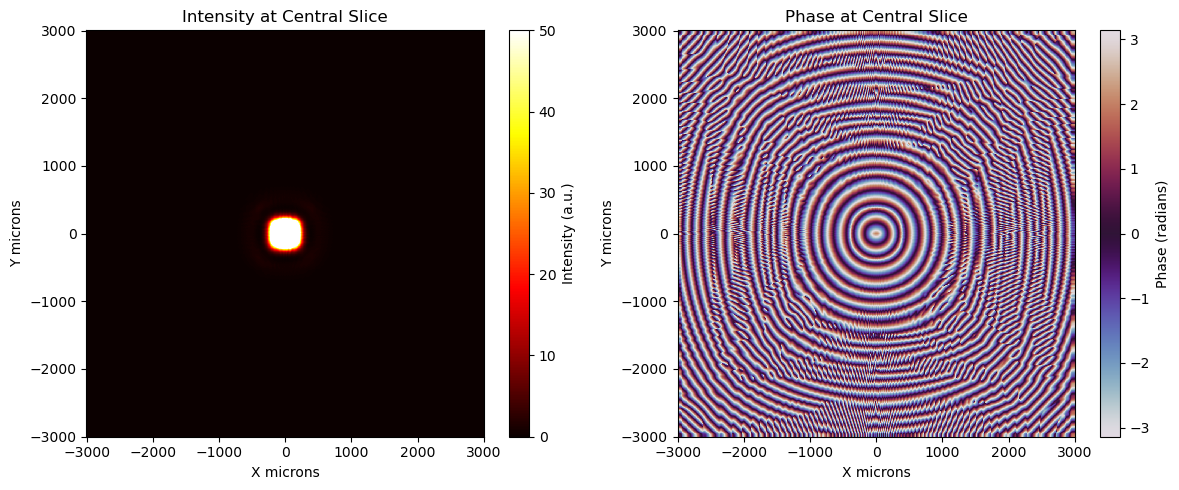

In [ ]:
# Select a slice to visualize (e.g., central slice)
slice_index = nz // 2
slice_index = 108
field_slice = dfl[:, :, slice_index]

# Plot intensity and phase of the field
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pcolormesh(x_mesh * 1e6, y_mesh * 1e6,np.abs(field_slice) ** 2, cmap="hot", shading="auto", vmin=0, vmax=50)
plt.colorbar(label="Intensity (a.u.)")
plt.title("Intensity at Central Slice")
plt.xlabel("X microns")
plt.ylabel("Y microns")

plt.subplot(1, 2, 2)
plt.pcolormesh(x_mesh * 1e6, y_mesh * 1e6,np.angle(field_slice), cmap="twilight", shading="auto")
plt.colorbar(label="Phase (radians)")
plt.title("Phase at Central Slice")
plt.xlabel("X microns")
plt.ylabel("Y microns")

plt.tight_layout()
#plt.show()

# Propagating the field

We use Fourier optics to propagate the field. This code is adapted to python from the book Computational Fourier Optics with Matlab (Voelz), and developped in past LBNL SULI internships.

Make sure to always verify the no aliasing condition: dx<lambda.*z/L

In [ ]:
# code borrowed from https://github.com/mmorst/Supreme/blob/master/supreme.py

# Centered Fourier Transform functions
def ft(t):
    return np.fft.fftshift( np.fft.fft2(np.fft.ifftshift(t)))

def ift(t):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(t)))

# Centered frequency scaling function
def fs(t):
    # works with Matlab, breaks with python
    #return (np.arange(0,1/(t[1]-t[0]),1/((t[1]-t[0])*len(t)))) - (1/(t[1]-t[0])-np.mod(len(t),2)*1/((t[1]-t[0])*len(t)))/2
    
    # from https://stackoverflow.com/questions/3694918/how-to-extract-frequency-associated-with-fft-values-in-python
    N = len(t)
    df_cpm = 1/(t[-1]-t[0])
    f_cpm = np.fft.fftshift(np.array([df_cpm*n if n<N/2 else df_cpm*(n-N) for n in range(N)]))
    return f_cpm

# The propagation function (angular spectrum method)
def propTF(E_in,L_m,lambda_m,z_m):
    #get input field array size
    (Nx, Ny)=np.shape(E_in); 
    dx=L_m/Nx; #sample interval

    #(dx<lambda.*z/L)

    fx = fs(np.arange(Nx)*dx)
    if Ny>2:
        fy = fs(np.arange(Ny)*dx)
    else:
        fy = 0

    [FX,FY]= np.meshgrid(fx,fy)

    H=np.exp(-1j*np.pi*lambda_m*z_m*(FX**2+FY**2))

    E_out = ft(ft(E_in)*H)
    
    return E_out

## Propagating the field over 100 mm

We show how to propagate the beam over some distance using Fourier Optics (in just one line of code)

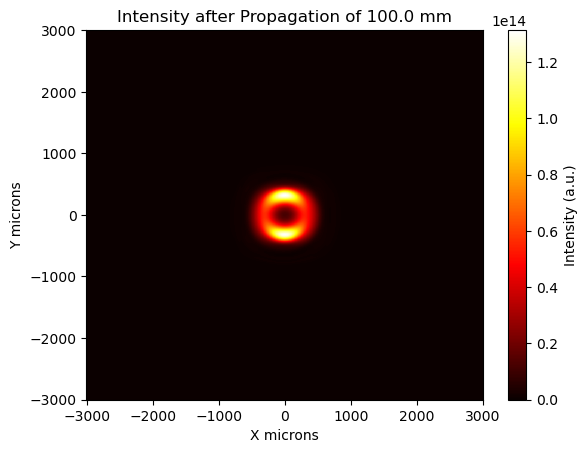

In [ ]:
# propagation distance
z_m = 0.1
# propagating the field 
field_slice_propagated = propTF(field_slice, grid_size*nx, lambda_0, z_m)

aliasing = lambda_0*z_m/grid_size
aliasing_flag = (lambda_0*z_m/grid_size > 1)
if aliasing_flag:
    print("Aliasing may occur: lambda*z/grid_size = {aliasing:.2f} > 1".format(aliasing=aliasing))

#plt.figure(figsize=(6, 5))
plt.pcolormesh(x_mesh * 1e6, y_mesh * 1e6,np.abs(field_slice_propagated) ** 2, cmap="hot", shading="auto")
plt.colorbar(label="Intensity (a.u.)")
plt.title(f"Intensity after Propagation of {z_m*1e3} mm")
plt.xlabel("X microns")
plt.ylabel("Y microns")
plt.show()  

## Looking at the whole progation longitudinally

It is often useful to propagate to a series of distances, to make sure there is no boundary effects or unexpected effects.

In [147]:
z_m = 0.1

# we split the propagation into Nz steps
Nz = 11
zs_m = np.linspace(0, z_m, Nz)
Ez = np.zeros((nx, ny, Nz), dtype=complex)
for i_z in range(Nz):
    Ez[:,:,i_z] = propTF(field_slice, grid_size*nx, lambda_0, zs_m[i_z])

I_long = np.abs(Ez[:, ny//2, :])**2


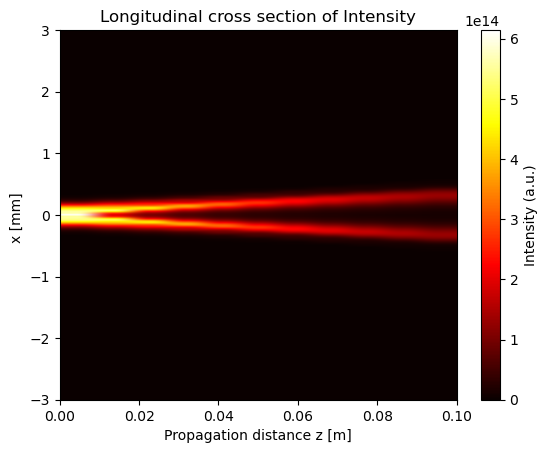

In [148]:
#plt.figure(figsize=(6, 5))
plt.imshow(I_long, extent=[zs_m.min(), zs_m.max(), x_mesh.min()*1e3, x_mesh.max()*1e3], cmap="hot", aspect="auto")
plt.colorbar(label="Intensity (a.u.)")
plt.title("Longitudinal cross section of Intensity")
plt.xlabel("Propagation distance z [m]")
plt.ylabel("x [mm] ")

plt.show() 

## Adding a grating at some distance z

At 100 mm, we would like the beam to be splitted by more than 1 mm
using the approx grating equation theta_rad = lambda/pitch, with theta_rad = 1 mm/100 mm = 0.01, we get pitch = 500 nm / 0.01 = 50 um

Note that given the screen size (which is fairly small.), we can't let beam duplicates exit the computational grid. We could zero pad if needed to look at smaller pitch or further distances.

For Wavefront sensing using lateral shearing , very low pitch are needed, since we essentially want to interfere the beam with itself. Generally you want to be in the first talbot plate: zT_m= p_m^2/lambda_m, e.g. if you set a Talbot distance of 100 mm, you would have p_m = sqrt(100 mm * 500 nm) ~ 220 um.



In [149]:
# grating pitch

p_m = 50e-6
grating = 0.5*(1+np.sign(np.sin(2*np.pi*y_mesh/p_m)))

# ideal phase grating
grating = np.exp(1j*(np.pi/2)*np.sin(2*np.pi*y_mesh/p_m))

In [150]:
zg_m = 0.1
zd_m = 0.1
field_before_grating = propTF(field_slice, grid_size*nx, lambda_0, z_m)
field_after_grating = field_before_grating * grating
field_grating_propagated = propTF(field_after_grating, grid_size*nx, lambda_0, zd_m)

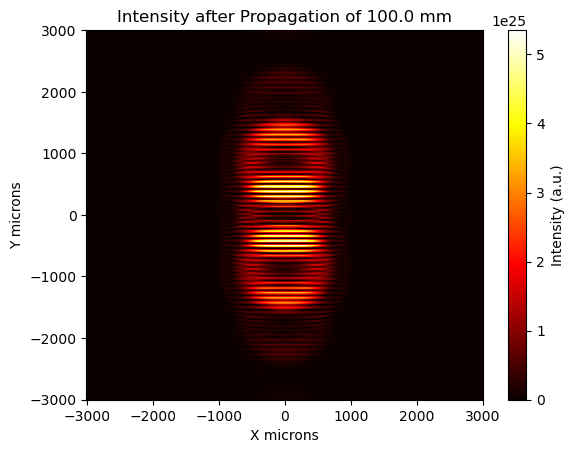

In [151]:
plt.pcolormesh(x_mesh * 1e6, y_mesh * 1e6,np.abs(field_grating_propagated) ** 2, cmap="hot", shading="auto")
plt.colorbar(label="Intensity (a.u.)")
plt.title(f"Intensity after Propagation of {z_m*1e3} mm")
plt.xlabel("X microns")
plt.ylabel("Y microns")
plt.show()  

In [152]:
Nz = 11
zs_m = np.linspace(0, zd_m, Nz)
Ez = np.zeros((nx, ny, Nz), dtype=complex)
for i_z in range(Nz):
    Ez[:,:,i_z] = propTF(field_after_grating, grid_size*nx, lambda_0, zs_m[i_z])

I_long = np.abs(Ez[:, ny//2, :])**2

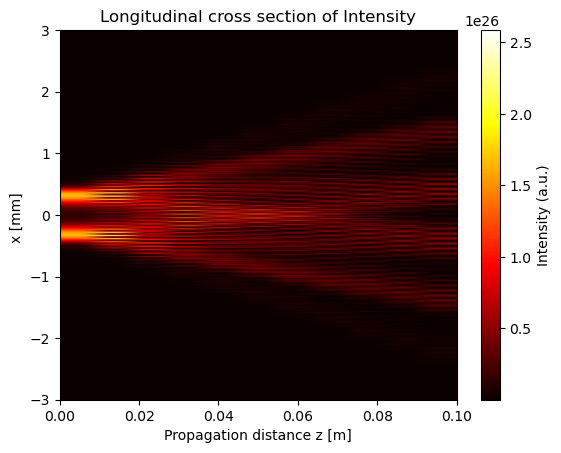

In [153]:
#plt.figure(figsize=(6, 5))
plt.imshow(I_long, extent=[zs_m.min(), zs_m.max(), x_mesh.min()*1e3, x_mesh.max()*1e3], cmap="hot", aspect="auto")
plt.colorbar(label="Intensity (a.u.)")
plt.title("Longitudinal cross section of Intensity")
plt.xlabel("Propagation distance z [m]")
plt.ylabel("x [mm] ")

plt.show() 

## Trying to use Lasy (doesn't work yet...)

https://github.com/LASY-org/lasy

https://colab.research.google.com/drive/1nPwgIUea6Jhzc9CSPDZXCcviWCmebjF1?usp=sharing

In [53]:
from lasy.laser import Laser
from lasy.profiles.transverse import TransverseProfileFromData

# First, 3D geometry
dimensions = "xyt"  # Use 3D geometry
#lo = (-50e-6, -50e-6, -150e-15)   # Lower bounds of the simulation box
#hi = (50e-6, 50e-6, 150e-15)      # Upper bounds of the simulation box
lo = (x_mesh[ 0,0], y_mesh[ 0,0], 0)   # Lower bounds of the simulation box
hi = (x_mesh[-1,-1], y_mesh[-1,-1], 0)      # Upper bounds of the simulation box

num_points = (nx, ny, 1)  # Number of points in each dimension. Use higher for production.

transverse_profile = TransverseProfileFromData(field_slice, [lo[0], lo[1]], [hi[0], hi[1]])

# this property is needed to construct laser somehow (not documented)
transverse_profile.is_cw = True

# >>>>issue here with transverse_profile.evaluate that should onlyu take 2 arguments (x,y)
 
# Constructing the object using 3D geometry might take a while to run depending on the hardware used.
laser_xyt = Laser(dimensions, lo, hi, num_points, transverse_profile)  # Laser

# help(transverse_profile.evaluate)

/opt/anaconda3/lib/python3.13/site-packages/lasy/profiles/transverse/transverse_profile_from_data.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  intensity_data = intensity_data.astype("float64")
/opt/anaconda3/lib/python3.13/site-packages/lasy/profiles/transverse/transverse_profile_from_data.py:79: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(intensity_data),


TypeError: TransverseProfile.evaluate() takes 3 positional arguments but 4 were given